In [65]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Pandas >= 0.25 required for this notebook
print(pd.__version__)

1.1.5


## Below is a modified and compressed version of Yuan's work on categories

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_cat_hierarchy = pd.read_csv('category_hierarchy.csv', delimiter='|',error_bad_lines=False)
df_items = pd.read_csv('items.csv',sep='|',error_bad_lines=False)
# fill NA values in category column
df_items["categories"] = df_items["categories"].fillna('[4300]')
df_items.head()

,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,[4300]
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]


In [5]:
# transform categories from str to int list
df_items['categories'] = df_items['categories'].map(lambda x: list(map(int,x.split("[")[1].split("]")[0].split(","))))

In [6]:
# from categories list generate parent_categories
df_indexed = df_cat_hierarchy.set_index(['category'])
df_indexed.head()

,parent_category
category,
0,75
1,1499
2,1082
3,3498
4,1623


In [7]:
flat_hierachy = df_indexed.copy()
flat_hierachy['layer3'] = df_indexed['parent_category'].map(lambda x: df_indexed.loc[x]['parent_category'])
flat_hierachy['layer4'] = flat_hierachy['layer3'].map(lambda x: df_indexed.loc[x]['parent_category'])


flat_hierachy['layer4'].value_counts().head()

3898    3097
2793     109
252       93
2346      81
3624      71
Name: layer4, dtype: int64

In [8]:
# set parent of null as null
df_indexed.loc[4300] = [4300]

## Now flatten the categories
Each row needs to contain only one category, not a list of categories

In [9]:
items_flat = df_items.copy()
items_flat = items_flat.explode('categories')
items_flat.head()

,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories
0,22665,861,4,0,490,2,66,2890
0,22665,861,4,0,490,2,66,855
0,22665,861,4,0,490,2,66,3908
0,22665,861,4,0,490,2,66,3909
1,28640,1366,10,1,537,0,101,4300


In [10]:
# parent_categories generate
items_flat['parent_categories'] = items_flat['categories'].map(lambda x : df_indexed.loc[x]['parent_category'].tolist())

In [11]:
items_flat.head()

,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,parent_categories
0,22665,861,4,0,490,2,66,2890,2832
0,22665,861,4,0,490,2,66,855,1178
0,22665,861,4,0,490,2,66,3908,3898
0,22665,861,4,0,490,2,66,3909,3898
1,28640,1366,10,1,537,0,101,4300,4300


In [12]:
# grandparent_categories generate
items_flat['grandparent_categories'] = items_flat['parent_categories'].map(lambda x : df_indexed.loc[x]['parent_category'].tolist())

In [13]:
# grand_grand_par_categories generate
items_flat['grand_grand_par_categories'] = items_flat['grandparent_categories'].map(lambda x : df_indexed.loc[x]['parent_category'].tolist())

## Filter out replenishments

In [52]:
# get the replenishment booleans from a pickle file generated in DL_Dataset
is_replen_file = open("is_replen.pickle", "rb")
is_replen = pickle.load(is_replen_file)
is_replen_file.close()

In [42]:
# read in orders and make sure they are sorted in the same way as is_replen
df_orders = pd.read_csv("orders_before_dec.csv", sep = "|")
df_orders = df_orders.sort_values(["userID", "itemID"])

In [44]:
print(len(df_orders))
print(len(is_replen))

767131
767131


In [46]:
replenishments = df_orders[is_replen]
replenishments

,date,userID,itemID,order
540881,2020-10-09,0,20664,1
754276,2020-11-29,1,23055,2
480461,2020-09-23,2,23476,1
586060,2020-10-19,2,30829,1
590263,2020-10-20,3,4135,1
...,...,...,...,...
351114,2020-08-23,46131,32646,1
734036,2020-11-25,46132,1303,1
683867,2020-11-14,46133,5468,1
445416,2020-09-15,46134,21901,2


### Now join the category information with the orders

In [78]:
data = pd.merge(replenishments, items_flat, on="itemID")
print(len(data), "data entries")
data

669787 data entries


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,parent_categories,grandparent_categories,grand_grand_par_categories
0,2020-10-09,0,20664,1,408,4,0,284,0,66,236,2054,2346,3898
1,2020-10-09,0,20664,1,408,4,0,284,0,66,356,1303,2346,3898
2,2020-08-31,1421,20664,1,408,4,0,284,0,66,236,2054,2346,3898
3,2020-08-31,1421,20664,1,408,4,0,284,0,66,356,1303,2346,3898
4,2020-10-29,1421,20664,1,408,4,0,284,0,66,236,2054,2346,3898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669782,2020-10-30,46131,2649,1,1156,10,1,489,3,39,3775,2012,3898,3898
669783,2020-10-30,46131,2649,1,1156,10,1,489,3,39,4032,3898,3898,3898
669784,2020-10-30,46131,3499,5,143,6,1,282,0,146,4300,4300,4300,4300
669785,2020-11-25,46132,1303,1,772,10,2,503,0,-1,146,431,965,3898


In [132]:
orders_by_category = data.groupby(["categories"]).size().sort_values(ascending=False)
top15categories = orders_by_category.head(15)
print(top15categories)
print(orders_by_category.describe())

categories
3915    30772
3914    23993
3912    14312
1763    11319
1760    10115
3924     9571
3457     6993
30       6814
3173     6749
1515     5604
3245     5346
3913     5268
2443     4942
3268     4888
3670     4791
dtype: int64
count     2824.000000
mean       237.176700
std       1008.785406
min          1.000000
25%          8.000000
50%         35.000000
75%        139.000000
max      30772.000000
dtype: float64


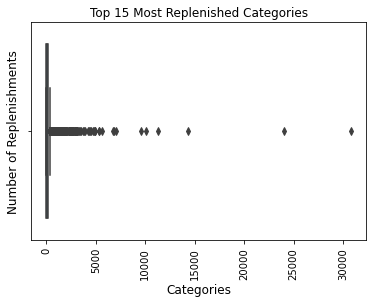

In [134]:
sns.boxplot(orders_by_category);
plt.ylabel('Categories', fontsize=12)
plt.xlabel('Number of Replenishments', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Replenished over Categories")
plt.show()

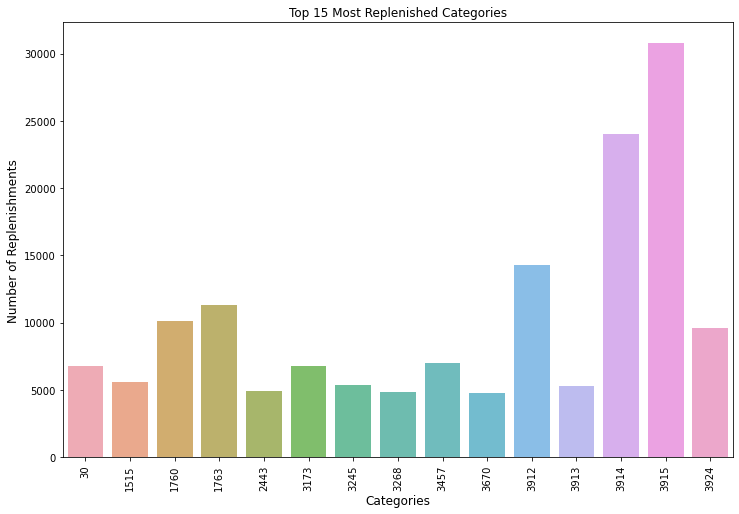

In [74]:
plt.figure(figsize=(12,8))
sns.barplot(top15categories.index, top15categories.values, alpha=0.8)
plt.ylabel('Number of Replenishments', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Top 15 Most Replenished Categories")
plt.show()

In [128]:
parent_category_data = data.explode('parent_categories')
print(parent_category_data.describe())
len(parent_category_data)

              userID         itemID          order          brand  \
count  672809.000000  672809.000000  672809.000000  672809.000000   
mean    23152.021262   16878.117690       1.728165     624.029919   
std     13285.293854    9372.697511       1.525566     481.664766   
min         0.000000       1.000000       1.000000       0.000000   
25%     11748.000000    9181.000000       1.000000     186.000000   
50%     23263.000000   18630.000000       1.000000     539.000000   
75%     34727.000000   24299.000000       2.000000    1040.000000   
max     46136.000000   32770.000000     100.000000    1513.000000   

           feature_1      feature_2      feature_3      feature_4  \
count  672809.000000  672809.000000  672809.000000  672809.000000   
mean        6.438374       0.287529     311.793974       1.022822   
std         2.819933       0.818529     163.286422       1.464988   
min         0.000000       0.000000      -1.000000      -1.000000   
25%         4.000000       0.0000

672809

the following plot is not yet correct as some parent categories are duplicate

In [129]:
orders_by_category = parent_category_data.groupby(["parent_categories"]).size().sort_values(ascending=False)
top15categories = orders_by_category.head(15)
print(top15categories)
print(orders_by_category.describe())

parent_categories
3898    187552
2231     24886
3027     14748
2542     14137
2762     12112
861      11318
1682     10566
2012      9865
489       9492
3726      9188
1543      8765
2134      8597
621       7540
1178      7493
3056      6540
dtype: int64
count       569.000000
mean       1182.441125
std        8093.654986
min           1.000000
25%          39.000000
50%         178.000000
75%         683.000000
max      187552.000000
dtype: float64


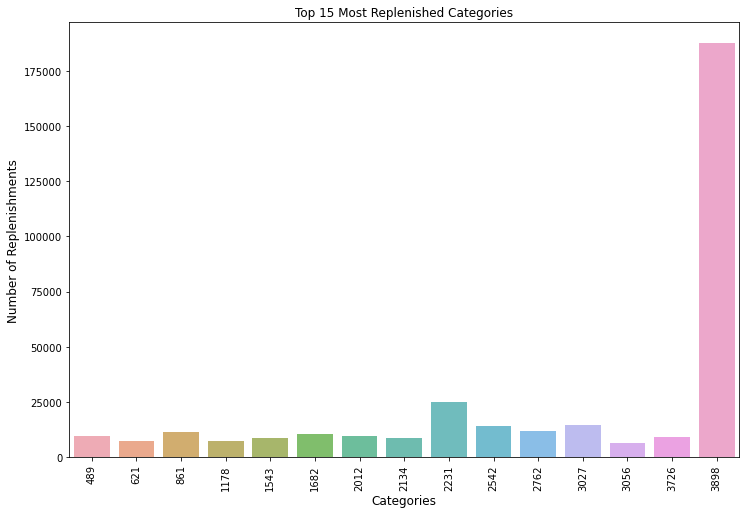

In [130]:
plt.figure(figsize=(12,8))
sns.barplot(top15categories.index, top15categories.values, alpha=0.8)
plt.ylabel('Number of Replenishments', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Top 15 Most Replenished Categories")
plt.show()